In [1]:
from ORE import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy import stats

Standard Monte Carlo mehods approximate high-dimensional hypercube integrals
$$
I[f] = \int_{[0, 1]^d}f(x)~dx
$$
by the sum
$$
I_N[f] = \frac{1}{N}\sum_{i=1}^Nf(x^{(i)})
$$
with points chosen randomly, giving r.m.s. error proportional to $N^{-1/2}$ and providing us with a confidence interval. Standard _quasi Monte Carlo_ (QMC) methods use the same equal-weight estimator, but choose the points systematically so that the error is roughly proportional to $N^{-1}$.

The key is to use points which are fairly uniformly spread within the hypercube, not clustered anywhere. The _star discrepancy_ $D^{*}_N(x^{(1)},\dots, x^{(N)})$ of a set of $N$ points is defined as
$$
D^{*}_N(x^{(1)},\dots, x^{(N)}) = \sup_{B=J}\left|\frac{A(B)}{N}-\lambda(B)\right|
$$
where $J$ is the set of all hyper-rectangles contained in $[0,1]^d$, $A(B)$ is the number of points in $B$, and $\lambda(B)$ is the measure of $B$. There exist _low discrepancy_ sequences for which
$$
D_N^*(x^{(1)},\dots, x^{(N)})\le C\frac{(\log N)^d}{N}.
$$
This is important because of the _Koksma-Hlawka inequality_
$$
\big|I_N[f]-I[f]\big|
\le V(f)D_N^*(x^{(1)},\dots, x^{(N)}), 
$$
where $V(f)$ is the _Hardy-Krause_ variation of $f$. 

There is a problem: this is not a useful error bound since 

-  In financial applications $f$ often isn't even bounded;

-  Even when $f$ is bounded, it is often not sufficiently differentiable and estimating $V(f)$ is computationally demanding.

However, the inequality is still useful because of what it tells us about the asymptotic behaviour of the Monte Carlo error for low discrepancy sequences:
$$
\text{Error} \le C_d\frac{(\log N)^d}{N}.
$$
As the dimension $d$ grows large, it becomes increasingly difficult to guarantee that all projections of a sequence are well distributed. This difficulty is reflected in the discrepancy bound above. For small dimension (e.g. $d<10$) the above bound is much better than the $O(N^{-1/2})$ r.m.s. error for standard Monte Carlo. However, for large dimensions $(\log N)^d$ could be enormous, so it is not necessarily clear there is any benefit to using the low discrepancy sequence. Much of the subtlety of QMC arises from the need to reduce the effective dimension of the problem so that these benefits are realised. 

The most popular QMC approach uses _Sobol sequences_, which have the property that for small dimensions $d < 40$ the subsequence $2^m\le i \le 2^{m+1}$ of length $2^m$ has precisely $2^{m-d}$ points in each of the sub-cubes of volume $2^{-d}$ formed by bisecting the unit hypercube in each dimension. Similar properties hold with other pieces. 

Let's make a visual comparison of a Sobol sequence and a pseudo-random sequence in the unit cube. The following function generates sequences in the unit hypercube, using either pseudo-random numbers or Sobol numbers.

In [2]:
def get_uniform_sequence(dimensions, length, low_discrepancy):
    if low_discrepancy:
        usg = UniformLowDiscrepancySequenceGenerator(dimensions)
    else:
        usg = UniformRandomSequenceGenerator(dimensions, 
                                             UniformRandomGenerator())
    samples = np.zeros((dimensions, length))
    for i in range(length):
        samples[:, i] = usg.nextSequence().value()
    return samples

Now generate and plot the sequences...

In [3]:
num_samples = 10000
sobol_samples = get_uniform_sequence(2, num_samples, True)
random_samples = get_uniform_sequence(2, num_samples, False)

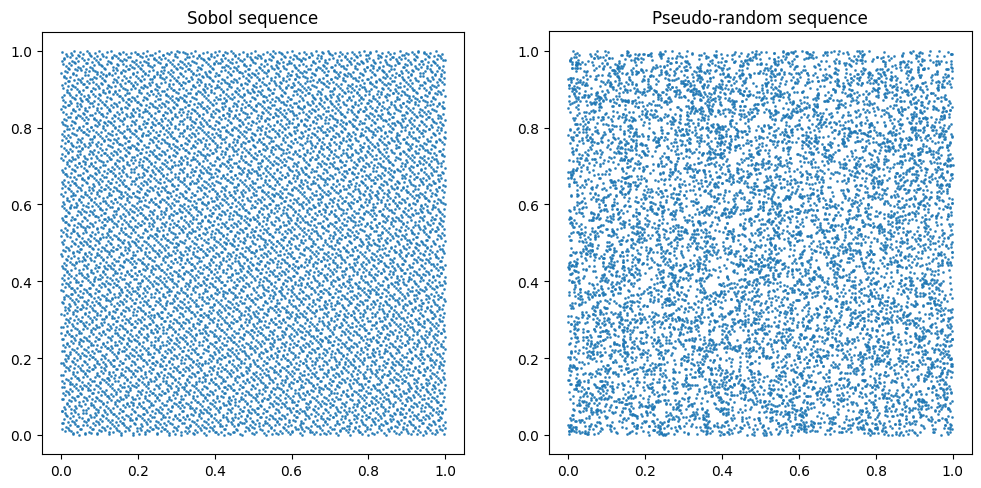

In [4]:
plt.rcParams['figure.figsize'] = [12, 10]
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, adjustable='box', aspect=1)
ax2 = fig.add_subplot(1, 2, 2, adjustable='box', aspect=1)
ax1.scatter(sobol_samples[0, :], sobol_samples[1, :], s=1, alpha=0.8)
ax1.set_title("Sobol sequence")
ax2.scatter(random_samples[0, :], random_samples[1, :], s=1, alpha=0.8)
ax2.set_title("Pseudo-random sequence")
plt.show()

The Sobol sequence is clearly more evenly distributed. We now investigate the improvement in convergence associated with using such a sequence in a Monte Carlo simulation. As our friut fly we’ll take the example of a European call option, written on an asset undergoing a geometric Brownian motion (GBM). First set up some dates:

In [5]:
today = Date(5, March, 2014)
Settings.instance().evaluationDate = today

Building the option requires only the specification of its contract, i.e. its payoff and its exercise.

In [6]:
tenor = 1
strike = 100.0
exercise_date = today + Period(tenor, Years)
payoff = PlainVanillaPayoff(Option.Call, strike)
option = EuropeanOption(payoff, 
                        EuropeanExercise(exercise_date))

Assume a flat risk-free rate and volatility. 

In [7]:
initial_price = 100.0
risk_free_rate = 0.05
volatility = 0.1
u = SimpleQuote(initial_price)
r = SimpleQuote(risk_free_rate)
vol = SimpleQuote(volatility)
riskFreeCurve = FlatForward(0, 
                            TARGET(), 
                            QuoteHandle(r), 
                            Actual365Fixed())
sigma = BlackConstantVol(0, 
                         TARGET(), 
                         QuoteHandle(vol), 
                         Actual365Fixed())

Now instantiate the GBM with the value of the underlying and the curves we just built. 

In [8]:
bs_process = BlackScholesProcess(QuoteHandle(u),
                                 YieldTermStructureHandle(riskFreeCurve),
                                 BlackVolTermStructureHandle(sigma))

We can obtain the exact option price by using the analytic engine, which prices the call using the Black-Scholes formula. 

In [9]:
engine = AnalyticEuropeanEngine(bs_process)
option.setPricingEngine(engine)
exact_npv = option.NPV()

We now aim to price the option again using Monte Carlo methods. 

The quality of Sobol sequences deteriorates with dimension. We can observe this effect by plotting a high-dimensional sobol sequence and projecting onto the highest dimensions. By refreshing the cell below a few times we see some strange distributions. 

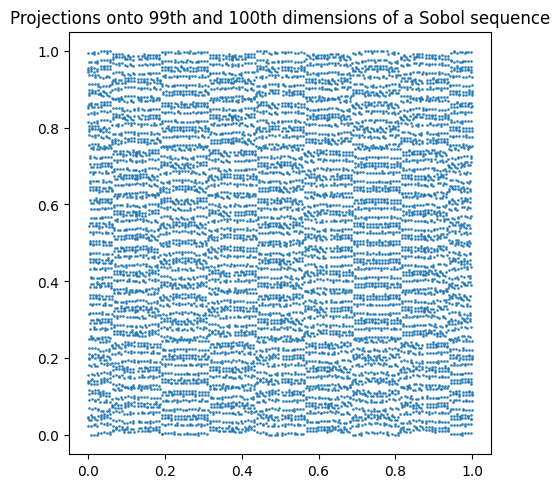

In [10]:
plt.rcParams['figure.figsize'] = [12, 10]
num_samples = 10000
sobol_samples = get_uniform_sequence(100, num_samples, True)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, adjustable='box', aspect=1)
plt.scatter(sobol_samples[98, :], sobol_samples[99, :], s=1, alpha=0.8)
ax1.set_title("Projections onto 99th and 100th dimensions of a Sobol sequence")
plt.show()

Why does this matter? For numerical simulation, a continuous stochastic process is often modeled as a discrete process. Because the time discretization often requires using a large number $M$ of small steps, the resulting expected value integrals are often very high dimensional. When using standard normal random inputs for Monte Carlo simulation, we can express the expectation as a multi-dimensional integral
$$
V = \mathbb{E}\big[\hat{f}(\hat{S})\big] = \int \hat{f}(\hat{S})\phi(Z)~dZ,
$$
where $\phi(Z)$ is a multi-dimensional standard normal p.d.f. Putting $Z_n = \Phi^{-1}(U_n)$ turns this into an integral over a an $M$-dimensional hypercube
$$
V = \mathbb{E}\big[\hat{f}(\hat{S})\big] = \int \hat{f}(\hat{S})~dU.
$$
This is then approximated as
$$
\frac{1}{N}\sum_n\hat{f}(\hat{S}^{(n)}).
$$

Each path calculation involves the computations
$$
U\longrightarrow Z\longrightarrow \Delta W\longrightarrow\hat{S}\longrightarrow\hat{f}. 
$$
The key step here is the second: how best to convert the vector $Z$ into the vector $\Delta W$. By generating the sample paths using quasi-random sequences---so that they have superior distribution properties in the space of all paths associated with the given process---one can drastically reduce the Monte Carlo error in optimal circumstances. However, the improved accuracy of quasi Monte Carlo methods is generally lost for problems of high dimension due to the undesirable properties of high dimensional Sobol sequences we saw above. By choosing $\Delta W$ appropriately, it is possible to effectively reduce the dimension of the problem, so that this issue is mitigated.

A popular method for performing this dimension reduction is using a _Brownian bridge_ construction. The final Brownian value is constructed using $Z_1$:
$$
W_M = \sqrt{T}Z_1.
$$
Conditional on this, the midpoint value $W_{M/2}$ is normally distributed with mean $W_M/2$ and variance $T/4$, and so can be constructed as follows:
$$
W_{M/2} = \frac{1}{2}W_M + \frac{\sqrt{T}}{2}Z_2. 
$$
The quarter and three-quarters points can then be constructed as
$$
W_{M/4} = \frac{1}{2}W_{M/2} + \sqrt{\frac{T}{8}}Z_3,\\
W_{M/4} = \frac{1}{2}(W_{M/2} + W_M) + \sqrt{\frac{T}{8}}Z_4,
$$
and the procedure continued recursively until all Brownian values are defined (this assumes $M$ is a power of 2 -- if this is not the case, the
implementation is slightly more complex.) Although the total variance associated with each $W_n$ in this representation is the same as in the standard discretization, the variance associated with the $Z_n$'s is no longer constant. It has been redistributed so that much more of the variance is contained in the first few steps of the Brownian bridge discretisation, while the later steps have signicantly smaller variance due to the factor of two reduction in each step. This reduces the effective dimension of the random process simulation, which increases the accuracy of quasi Monte Carlo techniques. 

We perform the Brownian bridge construction using the following function.

In [11]:
from numpy import sqrt, log2, reshape
def bb(W):
    W = W.copy()
    N = W.shape[0]
    # perform Brownian Bridge interpolation
    M = int(log2(N))
    if N != 2**M:
        raise ValueError('number of timesteps not a power of 2')
    for m in range(1, M+1):
        mask = np.arange(2**m).reshape((-1,2)).T.flatten()
        W[mask,:] = np.vstack(\
        [ 0.5*W[:2**(m-1),:] + W[2**(m-1):2**m,:]/sqrt(2)**(m+1), \
        0.5*W[:2**(m-1),:] - W[2**(m-1):2**m,:]/sqrt(2)**(m+1) ])  
    W = sqrt(tenor)*W
    return W

We now defie a function for generating sample paths. Note that we do not strictly need to perform any discretisation; the solution to a GBM can be solved analytically. Moreover, since a European option only depends on the final price of the underlying, we do not even need to simulate the whole path, only the terminal value. However, in the following function we discretise the process via the Euler method in order to examine the QMC method in a typical use case. 

In [12]:
def get_paths(uniform_seq, is_exact):
    num_paths = np.shape(uniform_seq)[1]
    timesteps = np.shape(uniform_seq)[0]
    h  = tenor/timesteps
    # generate Wiener increments
    Z = stats.norm.ppf(uniform_seq)
    dW = bb(Z)
    # generate paths
    S = initial_price*np.ones((num_paths, ))
    if is_exact:
        for n in range(timesteps):
            S  *= np.exp(volatility*dW[n, :])
        S *= math.exp((risk_free_rate - 0.5*(volatility**2))*tenor)
    else:
        for n in range(timesteps):
            S  *= 1 + risk_free_rate*h + volatility*dW[n, :]
    return S

We now generate the Monte Carlo paths and keep track of the estimate using the following function:

In [13]:
def monte_carlo_simulation(uniform_seq, is_exact):
    # get paths
    num_paths = np.shape(uniform_seq)[1]
    paths = get_paths(uniform_seq, is_exact)
    # compute estimate
    run_sum = 0
    mc_npv = np.zeros(num_paths)
    discount = riskFreeCurve.discount(exercise_date)
    for i in range(num_paths):
        run_sum += discount * payoff(paths[i])
        mc_npv[i] =  run_sum/(i + 1)
    return mc_npv

Now generate our uniform sequences. We use a large numbe of timesteps so that the weak approximation error of the discretisation scheme is small. 

In [14]:
num_paths = 1000
timesteps = 2**7
rand_uniform_seq = get_uniform_sequence(timesteps, num_paths, False)
sobol_uniform_seq = get_uniform_sequence(timesteps, num_paths, True)

Compute and plot the absolute errors of each approach as a function of the number of sample paths.

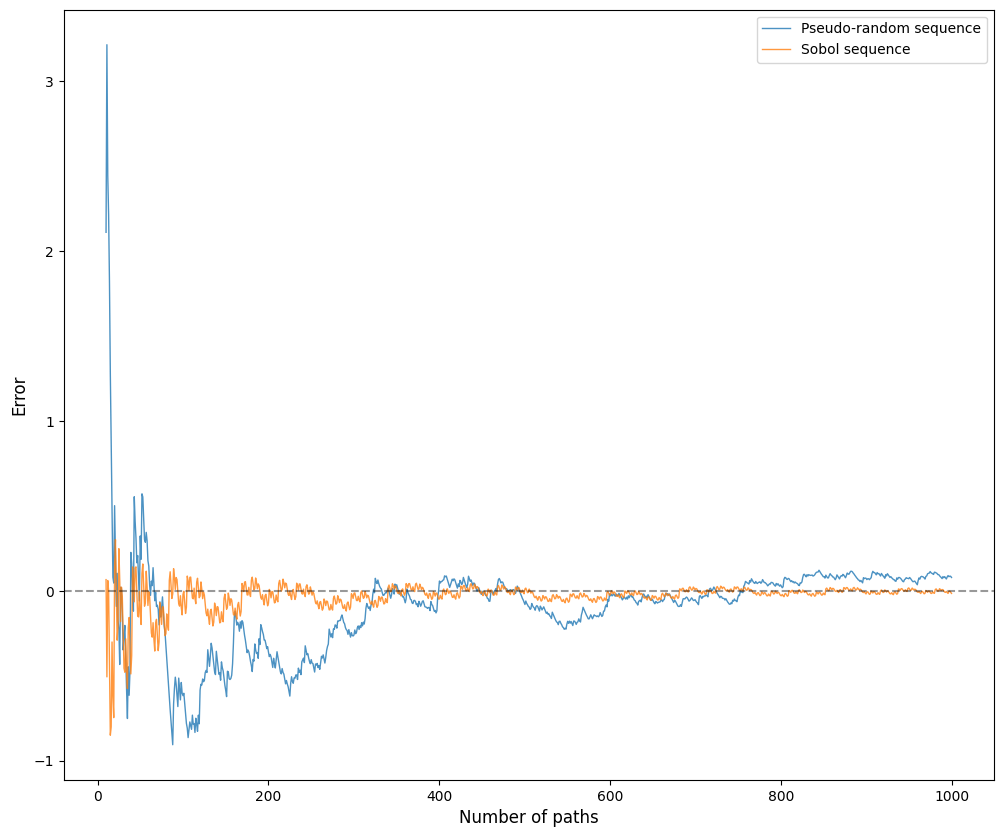

In [15]:
mc_errors = monte_carlo_simulation(rand_uniform_seq, False) - exact_npv
qmc_errors = monte_carlo_simulation(sobol_uniform_seq, False) - exact_npv
figure, axis = plt.subplots()
plots = []
plots += axis.plot(range(num_paths)[10:num_paths], 
                   mc_errors[10:num_paths], 
                   lw = 1, 
                   alpha = 0.8,
                   label = "Pseudo-random sequence")
plots += axis.plot(range(num_paths)[10:num_paths], 
                   qmc_errors[10:num_paths], 
                   lw = 1, 
                   alpha = 0.8,
                   label = "Sobol sequence")
labels = [p.get_label() for p in plots]
legend = axis.legend(plots, labels)
axis.set_xlabel("Number of paths", size=12)
axis.set_ylabel("Error", size=12)
axis.axhline(y=0, color='k', linestyle='--', alpha=0.4)
plt.show()

It is clear from the above plot that there is an impressive speed up in convergence when the low discrepancy sequence is used in place of the random sequence.



To examine the convergence more closely, we compute the absolute error and plot it on a log scale. 

In [16]:
pts = 14; timesteps = 2**7; is_exact = False
mc_errors = np.zeros(pts); qmc_errors = np.zeros(pts)
for p in range(2, pts+2):
    num_paths = 2**p 
    # generate pseudo-random samples
    rand_uniform_seq = get_uniform_sequence(timesteps, num_paths, False) 
    mc_npv = monte_carlo_simulation(rand_uniform_seq, is_exact)[-1]
    # generate pseudo-random samples
    sobol_seq = get_uniform_sequence(timesteps, num_paths, True) 
    qmc_npv = monte_carlo_simulation(sobol_seq, is_exact)[-1]
    # compute and store errors
    mc_err = mc_npv - exact_npv
    qmc_err = qmc_npv - exact_npv 
    mc_errors[p-2] = mc_err
    qmc_errors[p-2] = qmc_err

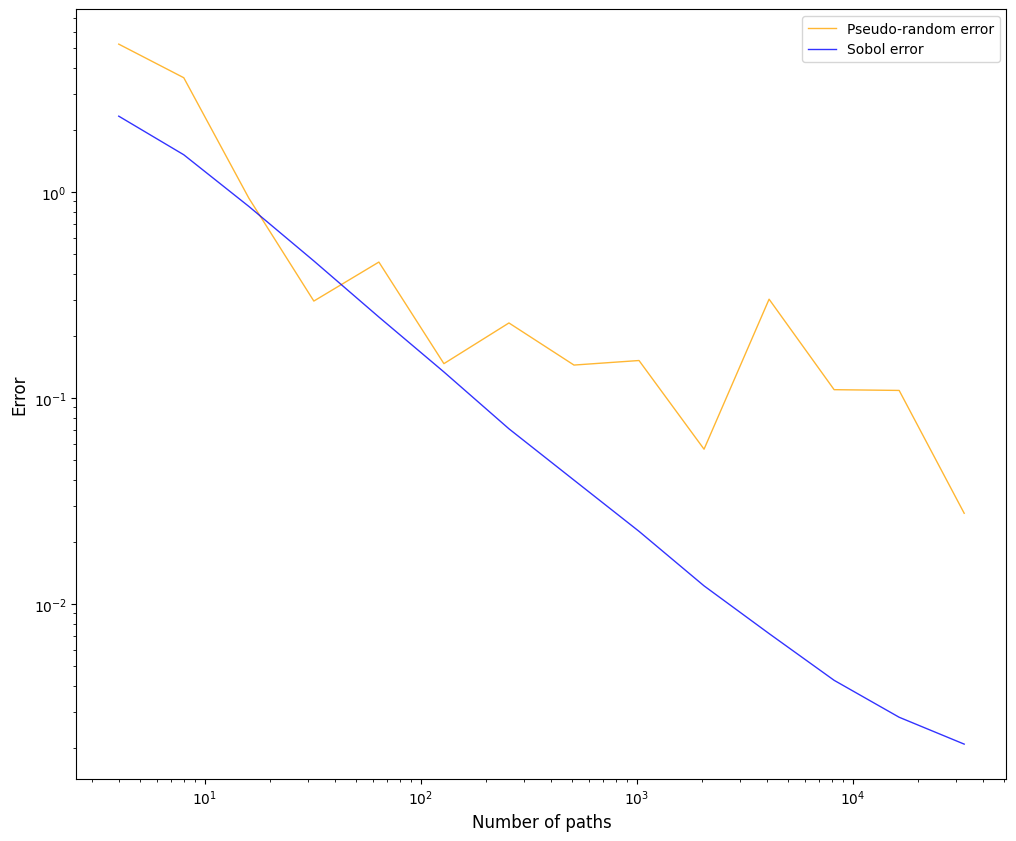

In [17]:
figure, axis = plt.subplots()
plots = []
paths = [2**p for p in range(2, pts+2)]
plots += axis.loglog(paths, 
                     abs(mc_errors),
                     linestyle='-',
                     lw = 1, 
                     alpha = 0.8,
                     color = 'orange',
                     label = "Pseudo-random error")
plots += axis.loglog(paths, 
                     abs(qmc_errors),
                     linestyle='-',
                     lw = 1, 
                     alpha = 0.8,
                     color = 'blue',
                     label = "Sobol error")
labels = [p.get_label() for p in plots]
legend = axis.legend(plots, labels)
axis.set_xlabel("Number of paths", size=12)
axis.set_ylabel("Error", size=12)
plt.show()

We now inestigate the statistical properties of the paths generated using low discrepancy sequences. We aim to simulate a sinple Wiener process using Brownian increments generated from a Sobol sequence. In the interests of variety, we'll do this ore directly using QuantLib. We will use the following helper function to choose the QuantLib path generator.

In [18]:
def get_path_generator(timestep,
                       process,
                       length, 
                       low_discrepancy,
                       brownian_bridge):
    if low_discrepancy:
        usg = UniformLowDiscrepancySequenceGenerator(timestep)
        gsg = GaussianLowDiscrepancySequenceGenerator(usg)
        gpg = GaussianSobolPathGenerator(process, 
                                         length, 
                                         timestep, 
                                         gsg,
                                         brownian_bridge)
    else:
        usg = UniformRandomSequenceGenerator(timestep, UniformRandomGenerator())
        gsg = GaussianRandomSequenceGenerator(usg)
        gpg = GaussianPathGenerator(process, 
                                    length, 
                                    timestep, 
                                    gsg, 
                                    brownian_bridge)
    return gpg

Now specify the process and pass it into the appropriate path generator. Note that a Wiener process is a simple example of a Ornstein Uhlenbeck process. We select a low discrepancy generating sequence, and that the Brownian incrrements are generated using a Brownian bridge construction. 

In [19]:
timesteps = 2**7
mean = lambda x: 0
wiener_process = ExtendedOrnsteinUhlenbeckProcess(0, 1, 0, mean)
path_generator = get_path_generator(timesteps,
                                    wiener_process,
                                    tenor, 
                                    True,
                                    True)

Define a function to generate sample paths from our initialised generator. 

In [20]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = path_generator.next()    
        path = sample_path.value()  
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

Plot the results. 

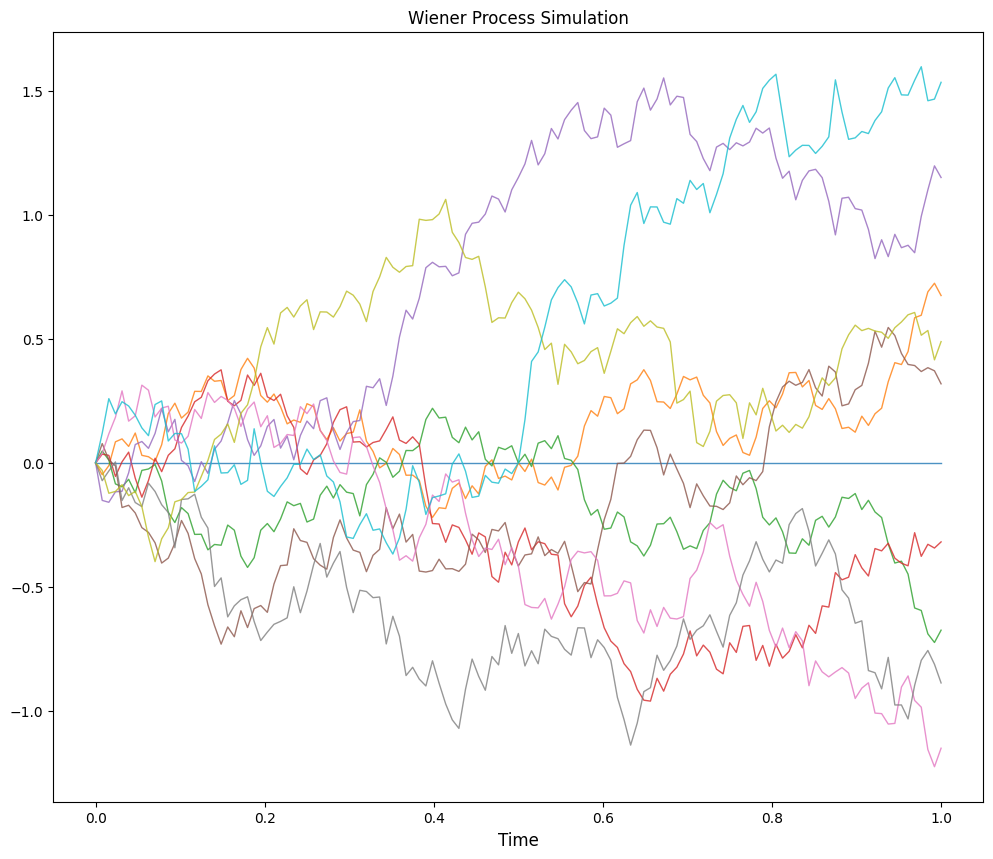

In [21]:
num_paths = 2**10
time, paths = generate_paths(num_paths, timesteps)
for i in range(10):
    plt.plot(time, paths[i, :], lw=1, alpha=0.8)
plt.title("Wiener Process Simulation")
ax = plt.gca()
ax.set_xlabel("Time", size=12)
plt.show()

Note that the first path generated is constant straight line. This is not a bug; the Sobol sequence has simply generated as it's first point $(0.5, 0.5, ..., 0.5)$, which translates to the (high probability) path consisting entirely of null increments.  

Finally, we look at the statistical properties of the set of sample path we just generated. We expect that 
$$
\mathbb{E}[W(t)] = 0,\quad
\text{Var}[W(t)] = t. 
$$
This is indeed what we observe. 

In [22]:
avg = [np.mean(paths[:, i]) for i in range(timesteps + 1)]
vol = [np.var(paths[:, i]) - i/timesteps for i in range(timesteps + 1)]

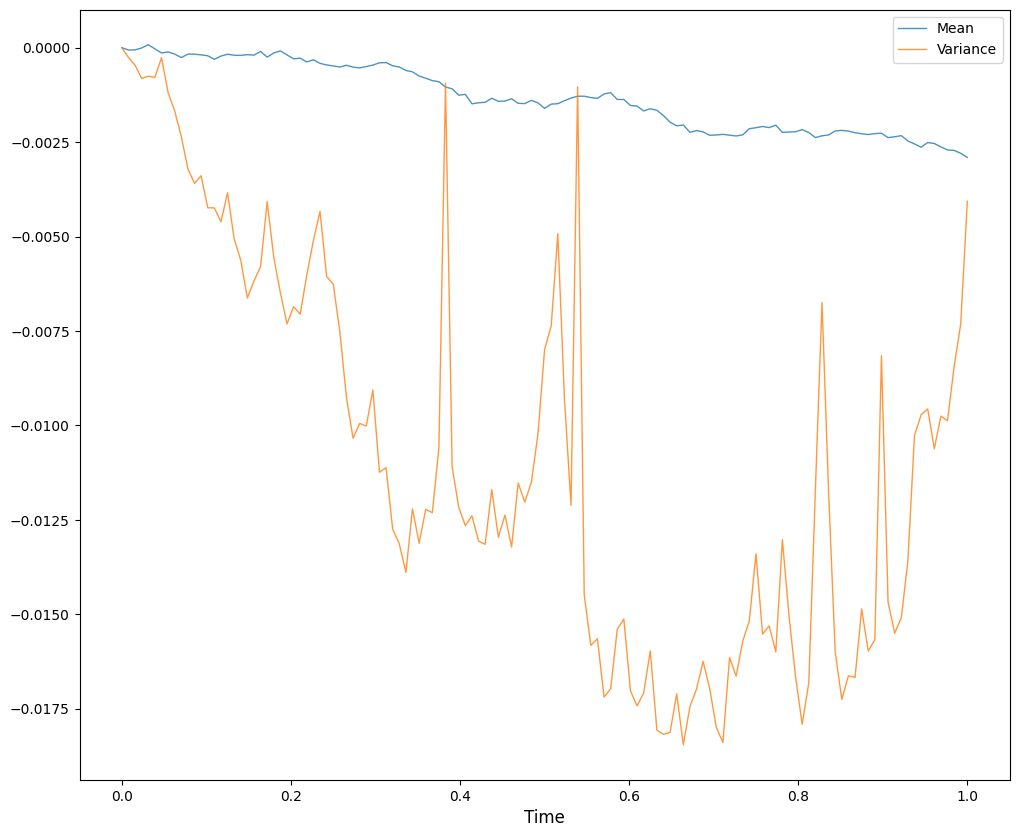

In [23]:
figure, axis = plt.subplots()
plots = []
plots += axis.plot(time, 
                   avg, 
                   lw = 1, 
                   alpha = 0.8,
                   label = "Mean")
plots += axis.plot(time, 
                   vol, 
                   lw = 1, 
                   alpha = 0.8,
                   label = "Variance")
labels = [p.get_label() for p in plots]
legend = axis.legend(plots, labels)
axis.set_xlabel("Time", size=12)
plt.show()